# Th∆∞ vi·ªán

In [2]:
import pandas as pd
import numpy as np
import re
from underthesea import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import zscore
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from transformers import AutoTokenizer, AutoModel, BertTokenizer, BertForSequenceClassification

import torch
from tqdm import tqdm

warnings.filterwarnings('ignore')

In [3]:
from underthesea import word_tokenize, pos_tag, sent_tokenize
import regex
import string

# DATA CLEANING

In [4]:
Reviews = pd.read_excel("Reviews.xlsx")

In [5]:
Reviews.head(2)

id Company Name       Cmt_day  \
0   4    Accenture    March 2025   
1   4    Accenture  January 2025   

                                               Title  \
0  M√¥i tr∆∞·ªùng tho·∫£i m√°i, √≠t √°p l·ª±c, c√≥ th·ªÉ l√†m vi...   
1                        C√¥ng ty tr·∫ª trung nƒÉng ƒë·ªông   

                                        What I liked  \
0  M√¥i tr∆∞·ªùng tho·∫£i m√°i, √≠t √°p l·ª±c, c√≥ th·ªÉ l√†m vi...   
1  C∆° s·ªü v·∫≠t ch·∫•t ƒë·∫πp, c√¥ng ty tr·∫ª trung nƒÉng ƒë·ªôn...   

                         Suggestions for improvement  Rating  \
0  C·∫ßn ƒë√°nh gi√° KPI kh√°ch quan v√† ph√¢n chia c√¥ng ...       4   
1  N√™n nghi√™n c·ª©u l·∫°i range l∆∞∆°ng c·ªßa th√¨ tr∆∞·ªùng....       4   

   Salary & benefits  Training & learning  Management cares about me  \
0                  4                    4                          4   
1                  3                    4                          4   

   Culture & fun  Office & workspace Recommend?  
0              4                   4        Yes  
1              4                   5        Yes

In [6]:
Overview_Companies = pd.read_excel("Overview_Companies.xlsx")
Overview_Companies.head(2)

id        Company Name    Company Type                  Company industry  \
0   0  1BITLAB Technology  IT Outsourcing  Software Development Outsourcing   
1   1               1test      IT Product     IT Services and IT Consulting   

     Company size      Country     Working days Overtime Policy  \
0  1-50 employees      Vietnam  Monday - Friday           No OT   
1  1-50 employees  South Korea  Monday - Friday           No OT   

                                    Company overview Our key skills  \
0  1BITLAB Technology\nC√¥ng ty c·ªï ph·∫ßn c√¥ng ngh·ªá ...            NaN   
1  1test\nIs an innovative educational technology...            NaN   

  Why you'll love working here  \
0                          NaN   
1                          NaN   

                                            Location  \
0  {'Ha Noi': ['81 L√™ ƒê·ª©c Th·ªç, Nam T·ª´ LI√™m, H√† N·ªô...   
1  {'Ho Chi Minh': ['Remote, District 1, Ho Chi M...   

                                                Href  
0  https://itviec.com/companies/1bitlab-technology\n  
1               https://itviec.com/companies/1test\n

In [8]:
Overview_Reviews = pd.read_excel("Overview_Companies.xlsx")
Overview_Reviews.head(2)

id        Company Name    Company Type                  Company industry  \
0   0  1BITLAB Technology  IT Outsourcing  Software Development Outsourcing   
1   1               1test      IT Product     IT Services and IT Consulting   

     Company size      Country     Working days Overtime Policy  \
0  1-50 employees      Vietnam  Monday - Friday           No OT   
1  1-50 employees  South Korea  Monday - Friday           No OT   

                                    Company overview Our key skills  \
0  1BITLAB Technology\nC√¥ng ty c·ªï ph·∫ßn c√¥ng ngh·ªá ...            NaN   
1  1test\nIs an innovative educational technology...            NaN   

  Why you'll love working here  \
0                          NaN   
1                          NaN   

                                            Location  \
0  {'Ha Noi': ['81 L√™ ƒê·ª©c Th·ªç, Nam T·ª´ LI√™m, H√† N·ªô...   
1  {'Ho Chi Minh': ['Remote, District 1, Ho Chi M...   

                                                Href  
0  https://itviec.com/companies/1bitlab-technology\n  
1               https://itviec.com/companies/1test\n

In [7]:
# Ch·ªçn c√°c c·ªôt c·∫ßn l·∫•y t·ª´ Overview_Companies
columns_to_add = [
    'id',
    'Company Type',
    'Company industry',
    'Company size',
    'Country',
    'Working days',
    'Overtime Policy'
]

# G·ªôp b·∫£ng b·∫±ng inner join theo c·ªôt 'id'
Reviews = Reviews.merge(
    Overview_Companies[columns_to_add],
    on='id',
    how='left'  # d√πng 'left' ƒë·ªÉ gi·ªØ nguy√™n t·∫•t c·∫£ d·ªØ li·ªáu trong Reviews
)

# Ki·ªÉm tra k·∫øt qu·∫£
Reviews.head()


id Company Name        Cmt_day  \
0   4    Accenture     March 2025   
1   4    Accenture   January 2025   
2   4    Accenture   October 2023   
3   4    Accenture  February 2025   
4   4    Accenture  February 2023   

                                               Title  \
0  M√¥i tr∆∞·ªùng tho·∫£i m√°i, √≠t √°p l·ª±c, c√≥ th·ªÉ l√†m vi...   
1                        C√¥ng ty tr·∫ª trung nƒÉng ƒë·ªông   
2               M√¥i tr∆∞·ªùng l√†m vi·ªác tho·∫£i m√°i vui v·∫ª   
3                       good environment for fresher   
4              M√¥i tr∆∞·ªùng l√†m vi·ªác tho·∫£i m√°i, vui v·∫ª   

                                        What I liked  \
0  M√¥i tr∆∞·ªùng tho·∫£i m√°i, √≠t √°p l·ª±c, c√≥ th·ªÉ l√†m vi...   
1  C∆° s·ªü v·∫≠t ch·∫•t ƒë·∫πp, c√¥ng ty tr·∫ª trung nƒÉng ƒë·ªôn...   
2  M·ªôi ng∆∞·ªùi th√¢n thi·ªán, gi√∫p ƒë·ª° l·∫´n nhau. Ch∆∞∆°ng...   
3  good env. for fresher to learn and improve the...   
4  - VƒÉn ph√≤ng ƒë·∫πp, c∆° s·ªü v·∫≠t ch·∫•t t·ªët\n- S·∫øp v√† ...   

                         Suggestions for improvement  Rating  \
0  C·∫ßn ƒë√°nh gi√° KPI kh√°ch quan v√† ph√¢n chia c√¥ng ...       4   
1  N√™n nghi√™n c·ª©u l·∫°i range l∆∞∆°ng c·ªßa th√¨ tr∆∞·ªùng....       4   
2  Do c√¥ng ty l√†m outsourcing v·ªÅ m·∫£ng system n√™n ...       3   
3  Need to forcus more on benefit and evaluate co...       3   
4  - Ph√°t tri·ªÉn vƒÉn ph√≤ng ƒë·ªÉ r·ªông r√£i h∆°n\n- C√¥ng...       4   

   Salary & benefits  Training & learning  Management cares about me  \
0                  4                    4                          4   
1                  3                    4                          4   
2                  3                    3                          3   
3                  2                    2                          3   
4                  3                    4                          4   

   Culture & fun  Office & workspace Recommend?                  Company Type  \
0              4                   4        Yes  IT Service and IT Consulting   
1              4                   5        Yes  IT Service and IT Consulting   
2              3                   3        Yes  IT Service and IT Consulting   
3              4                   4         No  IT Service and IT Consulting   
4              4                   3        Yes  IT Service and IT Consulting   

                Company industry       Company size  Country     Working days  \
0  IT Services and IT Consulting  301-500 employees  Vietnam  Monday - Friday   
1  IT Services and IT Consulting  301-500 employees  Vietnam  Monday - Friday   
2  IT Services and IT Consulting  301-500 employees  Vietnam  Monday - Friday   
3  IT Services and IT Consulting  301-500 employees  Vietnam  Monday - Friday   
4  IT Services and IT Consulting  301-500 employees  Vietnam  Monday - Friday   

  Overtime Policy  
0           No OT  
1           No OT  
2           No OT  
3           No OT  
4           No OT

In [66]:
# ƒê·ªô d√†i review
Reviews['combined_text'] = (
    Reviews['Title'].fillna('') + ' ' +
    Reviews['What I liked'].fillna('') + ' ' +
    Reviews['Suggestions for improvement'].fillna('')
)
Reviews['review_len'] = Reviews['combined_text'].astype(str).apply(lambda x: len(x.split()))

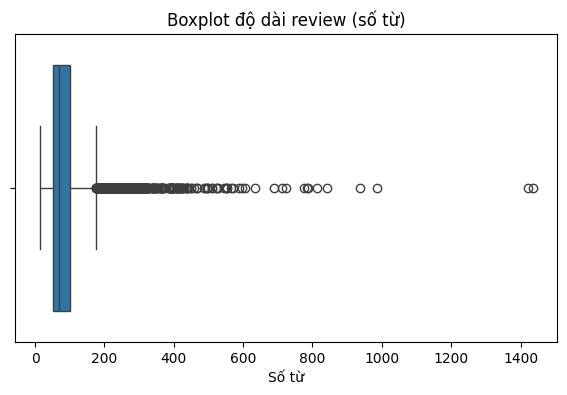

In [68]:
# Tr·ª±c quan h√≥a boxplot ƒë·ªÉ ki·ªÉm tra outliers
plt.figure(figsize=(7, 4))
sns.boxplot(x=Reviews['review_len'])
plt.title('Boxplot ƒë·ªô d√†i review (s·ªë t·ª´)')
plt.xlabel('S·ªë t·ª´')
plt.show()


## Data Cleaning

## Ti·ªÅn x·ª≠ l√Ω d·ªØ li·ªáu ti·∫øng Vi·ªát

In [69]:
# ƒê·ªçc stopwords
with open('vietnamese-stopwords.txt', encoding='utf-8') as f:
    stopwords = set([line.strip() for line in f.readlines() if line.strip()])

In [70]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z√°√†·∫£√£·∫°ƒÉ·∫Ø·∫±·∫≥·∫µ·∫∑√¢·∫•·∫ß·∫©·∫´·∫≠ƒë√©√®·∫ª·∫Ω·∫π√™·∫ø·ªÅ·ªÉ·ªÖ·ªá√≠√¨·ªâƒ©·ªã√≥√≤·ªè√µ·ªç√¥·ªë·ªì·ªï·ªó·ªô∆°·ªõ·ªù·ªü·ª°·ª£√∫√π·ªß≈©·ª•∆∞·ª©·ª´·ª≠·ªØ·ª±√Ω·ª≥·ª∑·ªπ·ªµ\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [71]:
def preprocess_vietnamese(text):
    text = clean_text(text)
    tokens = word_tokenize(text, format="text").split()
    tokens = [t for t in tokens if t not in stopwords]
    return ' '.join(tokens)

In [72]:
Reviews['text_processed'] = Reviews['combined_text'].apply(preprocess_vietnamese)

#### Normalize

In [13]:
import re
# H√†m ƒë·ªÉ chu·∫©n h√≥a c√°c t·ª´ c√≥ k√Ω t·ª± l·∫∑p
def normalize_repeated_characters(text):
    # Thay th·∫ø m·ªçi k√Ω t·ª± l·∫∑p li√™n ti·∫øp b·∫±ng m·ªôt k√Ω t·ª± ƒë√≥
    # V√≠ d·ª•: "l√≤nggggg" th√†nh "l√≤ng", "thi·ªátttt" th√†nh "thi·ªát"
    return re.sub(r'(.)\1+', r'\1', text)

# √Åp d·ª•ng h√†m chu·∫©n h√≥a cho vƒÉn b·∫£n
# print(normalize_repeated_characters(example))

In [73]:
Reviews['text_processed'] = Reviews['combined_text'].apply(lambda x: normalize_repeated_characters(x))


In [74]:
# Apply the process_text function
Reviews['text_processed'] = Reviews['combined_text'].apply(lambda x: process_text(x, emoji_dict, teen_dict, wrong_lst,english_dict))

In [75]:
Reviews.tail(5)

id                Company Name    Cmt_day  \
8412  477  Zuhlke Engineering Vietnam 2021-11-01   
8413  477  Zuhlke Engineering Vietnam 2021-11-01   
8414  477  Zuhlke Engineering Vietnam 2021-11-01   
8415  477  Zuhlke Engineering Vietnam 2021-11-01   
8416  477  Zuhlke Engineering Vietnam 2021-11-01   

                                            Title  \
8412                        M√¥i tr∆∞·ªùng c·ª±c k√¨ t·ªët   
8413            M√¥i tr∆∞·ªùng l√†m vi·ªác c·ª±c k·ª≥ c·ªüi m·ªü   
8414  C√¥ng ty t·ªët, nh√¢n vi√™n ƒë∆∞·ª£c c·∫•p Macbook Pro   
8415          Great place to leverage your skills   
8416                   M√¥i tr∆∞·ªùng r·∫•t t·ªët ƒë·ªÉ GROW   

                                           What I liked  \
8412  VƒÉn ho√°: M√¨nh r·∫•t ·∫•n t∆∞·ª£ng khi l√∫c ph·ªèng v·∫•n n...   
8413  - S·∫øp tho·∫£i m√°i, √Ω ki·∫øn c·ªßa m·ªçi nh√¢n vi√™n ƒë·ªÅu ...   
8414  Best interview experience: the interviewers ar...   
8415  - Environment: open, flat organization, divers...   
8416  + MacBook Max Options cho nh√¢n vi√™n.\n+ Magic ...   

                            Suggestions for improvement  Rating  \
8412  Hi·ªán t·∫°i c√¥ng ty c√≤n ch√¢n ∆∞·ªõt ch√¢n r√°o v√¥ Vi·ªát...       4   
8413  C√¥ng ty m·ªõi m·ªü, n√™n nhi·ªÅu th·ª© ch∆∞a ƒë∆∞·ª£c ƒë·ªãnh h...       4   
8414  As I started in Zuhlke Vietnam during lockdown...       5   
8415  Zuhlke Vietnam is still young, and we might ne...       5   
8416  + C√¥ng ty m·ªõi n√™n √≠t ng∆∞·ªùi bi·∫øt ƒë·∫øn, c√¥ng ty c...       5   

      Salary & benefits  Training & learning  Management cares about me  ...  \
8412                  4                    4                          5  ...   
8413                  4                    5                          5  ...   
8414                  5                    5                          5  ...   
8415                  4                    5                          4  ...   
8416                  4                    4                          5  ...   

      Overtime Policy                                        review_text  \
8412            No OT  VƒÉn ho√°: M√¨nh r·∫•t ·∫•n t∆∞·ª£ng khi l√∫c ph·ªèng v·∫•n n...   
8413            No OT  - S·∫øp tho·∫£i m√°i, √Ω ki·∫øn c·ªßa m·ªçi nh√¢n vi√™n ƒë·ªÅu ...   
8414            No OT  Best interview experience: the interviewers ar...   
8415            No OT  - Environment: open, flat organization, divers...   
8416            No OT  + MacBook Max Options cho nh√¢n vi√™n.\n+ Magic ...   

                                         processed_text pos_count neg_count  \
8412  vƒÉn_h√≥a ·∫•n_t∆∞·ª£ng ph·ªèng_v·∫•n fedback nhi·ªát_t√¨nh ...         0         0   
8413  s·∫øp tho·∫£i_m√°i √Ω_ki·∫øn nh√¢n_vi√™n qu√¢n_tr·ªçng ƒë·ªìng...         0         0   
8414  interview interviewers ch√∫ng_t√¥i th√¢n_thi·ªán di...         0         0   
8415  environment open flat organization diverse rec...         0         0   
8416  macbok t·ªëi_ƒëa t√πy magic chu·ªôt magic keyboard n...         0         0   

     label_sentiment Review_Year  \
8412               1        2021   
8413               1        2021   
8414               2        2021   
8415               1        2021   
8416               1        2021   

                                          combined_text review_len  \
8412  M√¥i tr∆∞·ªùng c·ª±c k√¨ t·ªët VƒÉn ho√°: M√¨nh r·∫•t ·∫•n t∆∞·ª£...        149   
8413  M√¥i tr∆∞·ªùng l√†m vi·ªác c·ª±c k·ª≥ c·ªüi m·ªü - S·∫øp tho·∫£i ...        211   
8414  C√¥ng ty t·ªët, nh√¢n vi√™n ƒë∆∞·ª£c c·∫•p Macbook Pro Be...        243   
8415  Great place to leverage your skills - Environm...        199   
8416  M√¥i tr∆∞·ªùng r·∫•t t·ªët ƒë·ªÉ GROW + MacBook Max Optio...        112   

                                         text_processed  
8412  m√¥i tr∆∞·ªùng c·ª±c k√¨ t·ªët vƒÉn ho√° m√¨nh r·∫•t ·∫•n t∆∞·ª£n...  
8413  m√¥i tr∆∞·ªùng l√†m vi·ªác c·ª±c k·ª≥ c·ªüi m·ªü s·∫øp tho·∫£i m√°...  
8414  c√¥ng t·ªët nh√¢n vi√™n ƒë∆∞·ª£c c·∫•p chuy√™n nghi·ªáp t·ªët ...  
8415  tuy·ªát qu√

#### Chu·∫©n h√≥a ti·∫øng Vi·ªát

In [76]:
def loaddicchar():
    uniChars = "√†√°·∫£√£·∫°√¢·∫ß·∫•·∫©·∫´·∫≠ƒÉ·∫±·∫Ø·∫≥·∫µ·∫∑√®√©·∫ª·∫Ω·∫π√™·ªÅ·∫ø·ªÉ·ªÖ·ªáƒë√¨√≠·ªâƒ©·ªã√≤√≥·ªè√µ·ªç√¥·ªì·ªë·ªï·ªó·ªô∆°·ªù·ªõ·ªü·ª°·ª£√π√∫·ªß≈©·ª•∆∞·ª´·ª©·ª≠·ªØ·ª±·ª≥√Ω·ª∑·ªπ·ªµ√Ä√Å·∫¢√É·∫†√Ç·∫¶·∫§·∫®·∫™·∫¨ƒÇ·∫∞·∫Æ·∫≤·∫¥·∫∂√à√â·∫∫·∫º·∫∏√ä·ªÄ·∫æ·ªÇ·ªÑ·ªÜƒê√å√ç·ªàƒ®·ªä√í√ì·ªé√ï·ªå√î·ªí·ªê·ªî·ªñ·ªò∆†·ªú·ªö·ªû·ª†·ª¢√ô√ö·ª¶≈®·ª§∆Ø·ª™·ª®·ª¨·ªÆ·ª∞·ª≤√ù·ª∂·ª∏·ª¥√ÇƒÇƒê√î∆†∆Ø"
    unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"

    dic = {}
    char1252 = 'aÃÄ|aÃÅ|aÃâ|aÃÉ|aÃ£|√¢ÃÄ|√¢ÃÅ|√¢Ãâ|√¢ÃÉ|√¢Ã£|ƒÉÃÄ|ƒÉÃÅ|ƒÉÃâ|ƒÉÃÉ|ƒÉÃ£|eÃÄ|eÃÅ|eÃâ|eÃÉ|eÃ£|√™ÃÄ|√™ÃÅ|√™Ãâ|√™ÃÉ|√™Ã£|iÃÄ|iÃÅ|iÃâ|iÃÉ|iÃ£|oÃÄ|oÃÅ|oÃâ|oÃÉ|oÃ£|√¥ÃÄ|√¥ÃÅ|√¥Ãâ|√¥ÃÉ|√¥Ã£|∆°ÃÄ|∆°ÃÅ|∆°Ãâ|∆°ÃÉ|∆°Ã£|uÃÄ|uÃÅ|uÃâ|uÃÉ|uÃ£|∆∞ÃÄ|∆∞ÃÅ|∆∞Ãâ|∆∞ÃÉ|∆∞Ã£|yÃÄ|yÃÅ|yÃâ|yÃÉ|yÃ£|AÃÄ|AÃÅ|AÃâ|AÃÉ|AÃ£|√ÇÃÄ|√ÇÃÅ|√ÇÃâ|√ÇÃÉ|√ÇÃ£|ƒÇÃÄ|ƒÇÃÅ|ƒÇÃâ|ƒÇÃÉ|ƒÇÃ£|EÃÄ|EÃÅ|EÃâ|EÃÉ|EÃ£|√äÃÄ|√äÃÅ|√äÃâ|√äÃÉ|√äÃ£|IÃÄ|IÃÅ|IÃâ|IÃÉ|IÃ£|OÃÄ|OÃÅ|OÃâ|OÃÉ|OÃ£|√îÃÄ|√îÃÅ|√îÃâ|√îÃÉ|√îÃ£|∆†ÃÄ|∆†ÃÅ|∆†Ãâ|∆†ÃÉ|∆†Ã£|UÃÄ|UÃÅ|UÃâ|UÃÉ|UÃ£|∆ØÃÄ|∆ØÃÅ|∆ØÃâ|∆ØÃÉ|∆ØÃ£|YÃÄ|YÃÅ|YÃâ|YÃÉ|YÃ£'.split(
        '|')
    charutf8 = "√†|√°|·∫£|√£|·∫°|·∫ß|·∫•|·∫©|·∫´|·∫≠|·∫±|·∫Ø|·∫≥|·∫µ|·∫∑|√®|√©|·∫ª|·∫Ω|·∫π|·ªÅ|·∫ø|·ªÉ|·ªÖ|·ªá|√¨|√≠|·ªâ|ƒ©|·ªã|√≤|√≥|·ªè|√µ|·ªç|·ªì|·ªë|·ªï|·ªó|·ªô|·ªù|·ªõ|·ªü|·ª°|·ª£|√π|√∫|·ªß|≈©|·ª•|·ª´|·ª©|·ª≠|·ªØ|·ª±|·ª≥|√Ω|·ª∑|·ªπ|·ªµ|√Ä|√Å|·∫¢|√É|·∫†|·∫¶|·∫§|·∫®|·∫™|·∫¨|·∫∞|·∫Æ|·∫≤|·∫¥|·∫∂|√à|√â|·∫∫|·∫º|·∫∏|·ªÄ|·∫æ|·ªÇ|·ªÑ|·ªÜ|√å|√ç|·ªà|ƒ®|·ªä|√í|√ì|·ªé|√ï|·ªå|·ªí|·ªê|·ªî|·ªñ|·ªò|·ªú|·ªö|·ªû|·ª†|·ª¢|√ô|√ö|·ª¶|≈®|·ª§|·ª™|·ª®|·ª¨|·ªÆ|·ª∞|·ª≤|√ù|·ª∂|·ª∏|·ª¥".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic

# ƒê∆∞a to√†n b·ªô d·ªØ li·ªáu qua h√†m n√†y ƒë·ªÉ chu·∫©n h√≥a l·∫°i
def covert_unicode(txt):
    dicchar = loaddicchar()
    return regex.sub(
        r'aÃÄ|aÃÅ|aÃâ|aÃÉ|aÃ£|√¢ÃÄ|√¢ÃÅ|√¢Ãâ|√¢ÃÉ|√¢Ã£|ƒÉÃÄ|ƒÉÃÅ|ƒÉÃâ|ƒÉÃÉ|ƒÉÃ£|eÃÄ|eÃÅ|eÃâ|eÃÉ|eÃ£|√™ÃÄ|√™ÃÅ|√™Ãâ|√™ÃÉ|√™Ã£|iÃÄ|iÃÅ|iÃâ|iÃÉ|iÃ£|oÃÄ|oÃÅ|oÃâ|oÃÉ|oÃ£|√¥ÃÄ|√¥ÃÅ|√¥Ãâ|√¥ÃÉ|√¥Ã£|∆°ÃÄ|∆°ÃÅ|∆°Ãâ|∆°ÃÉ|∆°Ã£|uÃÄ|uÃÅ|uÃâ|uÃÉ|uÃ£|∆∞ÃÄ|∆∞ÃÅ|∆∞Ãâ|∆∞ÃÉ|∆∞Ã£|yÃÄ|yÃÅ|yÃâ|yÃÉ|yÃ£|AÃÄ|AÃÅ|AÃâ|AÃÉ|AÃ£|√ÇÃÄ|√ÇÃÅ|√ÇÃâ|√ÇÃÉ|√ÇÃ£|ƒÇÃÄ|ƒÇÃÅ|ƒÇÃâ|ƒÇÃÉ|ƒÇÃ£|EÃÄ|EÃÅ|EÃâ|EÃÉ|EÃ£|√äÃÄ|√äÃÅ|√äÃâ|√äÃÉ|√äÃ£|IÃÄ|IÃÅ|IÃâ|IÃÉ|IÃ£|OÃÄ|OÃÅ|OÃâ|OÃÉ|OÃ£|√îÃÄ|√îÃÅ|√îÃâ|√îÃÉ|√îÃ£|∆†ÃÄ|∆†ÃÅ|∆†Ãâ|∆†ÃÉ|∆†Ã£|UÃÄ|UÃÅ|UÃâ|UÃÉ|UÃ£|∆ØÃÄ|∆ØÃÅ|∆ØÃâ|∆ØÃÉ|∆ØÃ£|YÃÄ|YÃÅ|YÃâ|YÃÉ|YÃ£',
        lambda x: dicchar[x.group()], txt)

In [77]:
Reviews["text_processed"] = Reviews["text_processed"].apply(lambda x: covert_unicode(x))

#### process_special_word - KH√îNG

In [78]:
def process_special_word(text):
    # c√≥ th·ªÉ c√≥ nhi·ªÅu t·ª´ ƒë·∫∑c bi·ªát c·∫ßn r√°p l·∫°i v·ªõi nhau
    new_text = ''
    text_lst = text.split()
    i= 0
    # kh√¥ng, ch·∫≥ng, ch·∫£...
    if 'kh√¥ng' in text_lst:
        while i <= len(text_lst) - 1:
            word = text_lst[i]
            #print(word)
            #print(i)
            if  word == 'kh√¥ng':
                next_idx = i+1
                if next_idx <= len(text_lst) -1:
                    word = word +'_'+ text_lst[next_idx]
                i= next_idx + 1
            else:
                i = i+1
            new_text = new_text + word + ' '
    else:
        new_text = text
    return new_text.strip()

In [79]:
Reviews["text_processed"] = Reviews["text_processed"].apply(lambda x: process_special_word(x))

#### process_postag_thesea

In [80]:
def process_postag_thesea(text):
    new_document = ''
    for sentence in sent_tokenize(text):
        sentence = sentence.replace('.','')
        ###### POS tag
        lst_word_type = ['N','Np','A','AB','V','VB','VY','R']
        # lst_word_type = ['A','AB','V','VB','VY','R']
        sentence = ' '.join( word[0] if word[1].upper() in lst_word_type else '' for word in pos_tag(process_special_word(word_tokenize(sentence, format="text"))))
        new_document = new_document + sentence + ' '
    ###### DEL excess blank space
    new_document = regex.sub(r'\s+', ' ', new_document).strip()
    return new_document

In [81]:
Reviews["text_processed"] = Reviews["text_processed"].apply(lambda x: process_postag_thesea(x))

In [82]:
# Remove Stopword
def remove_stopword(text, stopwords):
    ###### REMOVE stop words
    document = ' '.join('' if word in stopwords else word for word in text.split())
    #print(document)
    ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    return document

Reviews["text_processed"] = Reviews["text_processed"].apply(lambda x: remove_stopword(x,stopwords_lst))

In [83]:
Reviews.head(5)

id Company Name    Cmt_day  \
0   4    Accenture 2025-03-01   
1   4    Accenture 2025-01-01   
2   4    Accenture 2023-10-01   
3   4    Accenture 2025-02-01   
4   4    Accenture 2023-02-01   

                                               Title  \
0  M√¥i tr∆∞·ªùng tho·∫£i m√°i, √≠t √°p l·ª±c, c√≥ th·ªÉ l√†m vi...   
1                        C√¥ng ty tr·∫ª trung nƒÉng ƒë·ªông   
2               M√¥i tr∆∞·ªùng l√†m vi·ªác tho·∫£i m√°i vui v·∫ª   
3                       good environment for fresher   
4              M√¥i tr∆∞·ªùng l√†m vi·ªác tho·∫£i m√°i, vui v·∫ª   

                                        What I liked  \
0  M√¥i tr∆∞·ªùng tho·∫£i m√°i, √≠t √°p l·ª±c, c√≥ th·ªÉ l√†m vi...   
1  C∆° s·ªü v·∫≠t ch·∫•t ƒë·∫πp, c√¥ng ty tr·∫ª trung nƒÉng ƒë·ªôn...   
2  M·ªôi ng∆∞·ªùi th√¢n thi·ªán, gi√∫p ƒë·ª° l·∫´n nhau. Ch∆∞∆°ng...   
3  good env. for fresher to learn and improve the...   
4  - VƒÉn ph√≤ng ƒë·∫πp, c∆° s·ªü v·∫≠t ch·∫•t t·ªët\n- S·∫øp v√† ...   

                         Suggestions for improvement  Rating  \
0  C·∫ßn ƒë√°nh gi√° KPI kh√°ch quan v√† ph√¢n chia c√¥ng ...       4   
1  N√™n nghi√™n c·ª©u l·∫°i range l∆∞∆°ng c·ªßa th√¨ tr∆∞·ªùng....       4   
2  Do c√¥ng ty l√†m outsourcing v·ªÅ m·∫£ng system n√™n ...       3   
3  Need to forcus more on benefit and evaluate co...       3   
4  - Ph√°t tri·ªÉn vƒÉn ph√≤ng ƒë·ªÉ r·ªông r√£i h∆°n\n- C√¥ng...       4   

   Salary & benefits  Training & learning  Management cares about me  ...  \
0                  4                    4                          4  ...   
1                  3                    4                          4  ...   
2                  3                    3                          3  ...   
3                  2                    2                          3  ...   
4                  3                    4                          4  ...   

   Overtime Policy                                        review_text  \
0            No OT  M√¥i tr∆∞·ªùng tho·∫£i m√°i, √≠t √°p l·ª±c, c√≥ th·ªÉ l√†m vi...   
1            No OT  C∆° s·ªü v·∫≠t ch·∫•t ƒë·∫πp, c√¥ng ty tr·∫ª trung nƒÉng ƒë·ªôn...   
2            No OT  M·ªôi ng∆∞·ªùi th√¢n thi·ªán, gi√∫p ƒë·ª° l·∫´n nhau. Ch∆∞∆°ng...   
3            No OT  good env. for fresher to learn and improve the...   
4            No OT  - VƒÉn ph√≤ng ƒë·∫πp, c∆° s·ªü v·∫≠t ch·∫•t t·ªët\n- S·∫øp v√† ...   

                                      processed_text pos_count neg_count  \
0  m√¥i_tr∆∞·ªùng tho·∫£i_m√°i √°p_l·ª±c c√≥_th·ªÉ l√†m_vi·ªác hy...         0         0   
1  c∆°_s·ªü_v·∫≠t_ch·∫•t ƒë·∫πp_c√¥ng tr·∫ª ch·∫ø_ƒë·ªô l√†m_vi·ªác hy...         0         0   
2  m·ªôi th√¢n_thi·ªán gi√∫p_ƒë·ª° l·∫´n ch∆∞∆°ng_tr√¨nh intern...         0         0   
3  fresher learn ability y√™n_tƒ©nh opened flexible...         0         0   
4  vƒÉn_ph√≤ng ƒë·∫πp c∆°_s·ªü v·∫≠t_ch·∫•t t·ªët_s·∫øp ƒë·ªìng_nghi...         0         0   

  label_sentiment Review_Year  \
0               1        2025   
1               1        2025   
2               1        2023   
3               0        2025   
4               1        2023   

                                       combined_text review_len  \
0  M√¥i tr∆∞·ªùng tho·∫£i m√°i, √≠t √°p l·ª±c, c√≥ th·ªÉ l√†m vi...        105   
1  C√¥ng ty tr·∫ª trung nƒÉng ƒë·ªông C∆° s·ªü v·∫≠t ch·∫•t ƒë·∫πp...         72   
2  M√¥i tr∆∞·ªùng l√†m vi·ªác tho·∫£i m√°i vui v·∫ª M·ªôi ng∆∞·ªùi...         81   
3  good environment for fresher good env. for fre...         41   
4  M√¥i tr∆∞·ªùng l√†m vi·ªác tho·∫£i m√°i, vui v·∫ª - VƒÉn ph...         74   

                                      text_processed  
0  m√¥i_tr∆∞·ªùng tho·∫£i_m√°i √°p_l·ª±c c√≥_th·ªÉ l√†m_vi·ªác hy...  
1  c√¥ng tr·∫ª nƒÉng_ƒë·ªông_c∆°_s·ªü_v·∫≠t_ch·∫•t ƒë·∫πp_c√¥ng tr·∫ª...  
2  m√¥i_tr∆∞·ªùng l√†m_vi·ªác tho·∫£i_m√°i v·∫ª m·ªôi th√¢n_thi·ªá...  
3  environment fresher fresher learn ability y√™n_...  
4  m√¥i_tr∆∞·ªùng l√†m_vi·ªác tho·∫£i_m√°i v·∫ª vƒÉn_ph√≤ng ƒë·∫πp...  

[5 rows x 28 columns]

## LABELING

In [84]:
positive_words = [
    "·∫•n t∆∞·ª£ng", "xu·∫•t ch√∫ng", "tuy·ªát h·∫£o", "ƒë√°ng gi√°", "m∆∞·ª£t m√†",
    "v∆∞·ª£t mong ƒë·ª£i", "chu ƒë√°o", "y√™n t√¢m", "t·ªët ƒë·∫πp", "nhanh nh·∫πn",
    "d·ªÖ th∆∞∆°ng", "hi·∫øm g·∫∑p", "h·∫•p d·∫´n", "v·ªØng ch·∫Øc", "chu·∫©n ch·ªânh", "tin t∆∞·ªüng",
    "nh·∫π nh√†ng", "kh√©o l√©o", "tr√°ch nhi·ªám", "linh ho·∫°t",
    "ƒë·ªôc ƒë√°o", "h·ª£p l√Ω", "th·∫•u hi·ªÉu", "th√†nh th·∫°o", "t·ª± tin", "vui nh·ªôn", "s·∫°ch s·∫Ω", "chu·∫©n m·ª±c",
    "c·ªüi m·ªü", "t·∫≠n t√¨nh", "g∆∞∆°ng m·∫´u", "t·ªët nghi·ªáp", "k·ªπ nƒÉng", "th√†nh c√¥ng", "n·ªïi b·∫≠t", "ho√† ƒë·ªìng", "hi·ªán ƒë·∫°i",
    "ti·ªán l·ª£i", "s√°ng s·ªßa", "ƒëa nƒÉng", "x·ª©ng ƒë√°ng", "ph·ª•c v·ª•", "ƒë√°p ·ª©ng", "ph·∫•n kh·ªüi", "nƒÉng su·∫•t", "ƒëi·ªÉm c·ªông",
    "l√Ω t∆∞·ªüng", "nh·∫π nh√†ng", "qu√Ω gi√°", "ho√†n m·ªπ"
]

In [85]:
negative_words = [
    "t·∫ßm th∆∞·ªùng", "thi·∫øu s√≥t", "b·ª±c m√¨nh", "v√¥ l√Ω", "l·∫°nh l√πng",
    "l·ªôn x·ªôn", "n·∫£n", "r·ªáu r√£", "th·∫•t v·ªçng", "kh√≥ th·ªü",
    "k·ª≥ qu·∫∑c", "b·∫•p b√™nh", "ƒë√°ng lo", "thi·∫øu ki·ªÉm so√°t", "x√°o tr·ªôn",
    "thi·∫øu chuy√™n m√¥n", "m∆° h·ªì", "l·ªôn x·ªôn", "v√¥ t·ªï ch·ª©c", "kh√≥ n·∫Øm b·∫Øt",
    "b·∫•t ti·ªán", "nguy hi·ªÉm", "ng·ªõ ng·∫©n", "b·ª±c b·ªôi", "thi·∫øu hi·ªáu qu·∫£",
    "cƒÉng th·∫≥ng", "r·ªùi r·∫°c", "l√¢u l·∫Øc", "d·ªü", "l∆∞·ªùi bi·∫øng",
    "thi·∫øu tr√°ch nhi·ªám", "gian d·ªëi", "r·∫≠p khu√¥n", "tr·ªÖ n·∫£i", "k√©m c·ªèi",
    "kh√≥ ti·∫øp c·∫≠n", "l∆° l√†", "b·ªè m·∫∑c", "th·ª• ƒë·ªông", "xa c√°ch",
    "k√©m h·∫•p d·∫´n", "thi·∫øu ƒë·ªông l·ª±c", "ƒë·ªôc ƒëo√°n", "m·∫≠p m·ªù", "thi·∫øu minh b·∫°ch",
    "thi·∫øu chuy√™n s√¢u", "v√¥ c·∫£m", "x√∫c ph·∫°m", "xui x·∫ªo", "r√∫t lui",
    "th·∫•t b·∫°i", "c√£i v√£", "tr√¨ tr·ªá", "thi·∫øu logic", "l√†m m√†u",
    "ng·ªôt ng·∫°t", "kh√≥ hi·ªÉu", "g√¢y ·ª©c ch·∫ø", "qu√° t·∫£i", "thi·∫øu t√¥n tr·ªçng",
    "thi·∫øu h·ªó tr·ª£", "v√¥ tr√°ch nhi·ªám", "b·∫•t m√£n", "m·∫•t l√≤ng tin", "thi·∫øu linh ho·∫°t",
    "k·ª≥ th·ªã", "kh√≥ x·ª≠ l√Ω", "b·∫•t c√¥ng", "xa v·ªùi", "m·∫≠p m·ªù", 
    "gi·∫£ t·∫°o", "thi·∫øu t√≠nh ng∆∞·ªùi", "ƒë√® n√©n", "v√¥ l√Ω", "ch·∫≠m ch·∫°p"
]

In [86]:
from collections import Counter

# C√°c c·ªôt ƒë√°nh gi√°
rating_columns = [
    'Salary & benefits', 'Training & learning', 'Management cares about me',
    'Culture & fun', 'Office & workspace'
]

# H√†m ƒë·∫øm s·ªë t·ª´ t√≠ch c·ª±c / ti√™u c·ª±c
def count_pos_neg_words(text, pos_words, neg_words):
    text = text.replace("_", " ").lower()
    tokens = text.split()
    counter = Counter(tokens)
    pos_count = sum(counter[w] for w in pos_words if w in counter)
    neg_count = sum(counter[w] for w in neg_words if w in counter)
    return pos_count, neg_count

# T√≠nh pos_count v√† neg_count cho t·ª´ng d√≤ng
Reviews[['pos_count', 'neg_count']] = Reviews['text_processed'].apply(
    lambda x: pd.Series(count_pos_neg_words(x, positive_words, negative_words))
)

#  H√†m g√°n nh√£n c·∫£m x√∫c
def classify_sentiment(row):
    ratings = row[rating_columns].values
    pos_count = row['pos_count']
    neg_count = row['neg_count']

    # Logic ph√¢n lo·∫°i
    if all(r == 5 for r in ratings):
        return 2  # T√≠ch c·ª±c
    elif all(r >= 4 for r in ratings) and (pos_count > neg_count):
        return 2  # T√≠ch c·ª±c
    elif any(r <= 2 for r in ratings) and (ratings.mean() <= 3 or pos_count <= neg_count):
        return 0  # Ti√™u c·ª±c
    else:
        return 1  # Trung t√≠nh

#  G√°n nh√£n c·∫£m x√∫c
Reviews['label_sentiment'] = Reviews.apply(classify_sentiment, axis=1)


In [87]:
# Th·ªëng k√™ s·ªë l∆∞·ª£ng t·ª´ng lo·∫°i sentiment
def count_sentiment_distribution(df):
    sentiment_map = {0: "Ti√™u c·ª±c", 1: "Trung t√≠nh", 2: "T√≠ch c·ª±c"}
    counts = df['label_sentiment'].value_counts().sort_index()
    for label, name in sentiment_map.items():
        print(f"{name}: {counts.get(label, 0)} ph·∫£n h·ªìi")
count_sentiment_distribution(Reviews)


Ti√™u c·ª±c: 1947 ph·∫£n h·ªìi
Trung t√≠nh: 5352 ph·∫£n h·ªìi
T√≠ch c·ª±c: 1118 ph·∫£n h·ªìi


# EDA

In [88]:
# C√°c c·ªôt c·∫ßn ph√¢n t√≠ch
eda_columns = [
    "Rating",
    "Salary & benefits",
    "Training & learning",
    "Management cares about me",
    "Culture & fun",
    "Office & workspace"
]


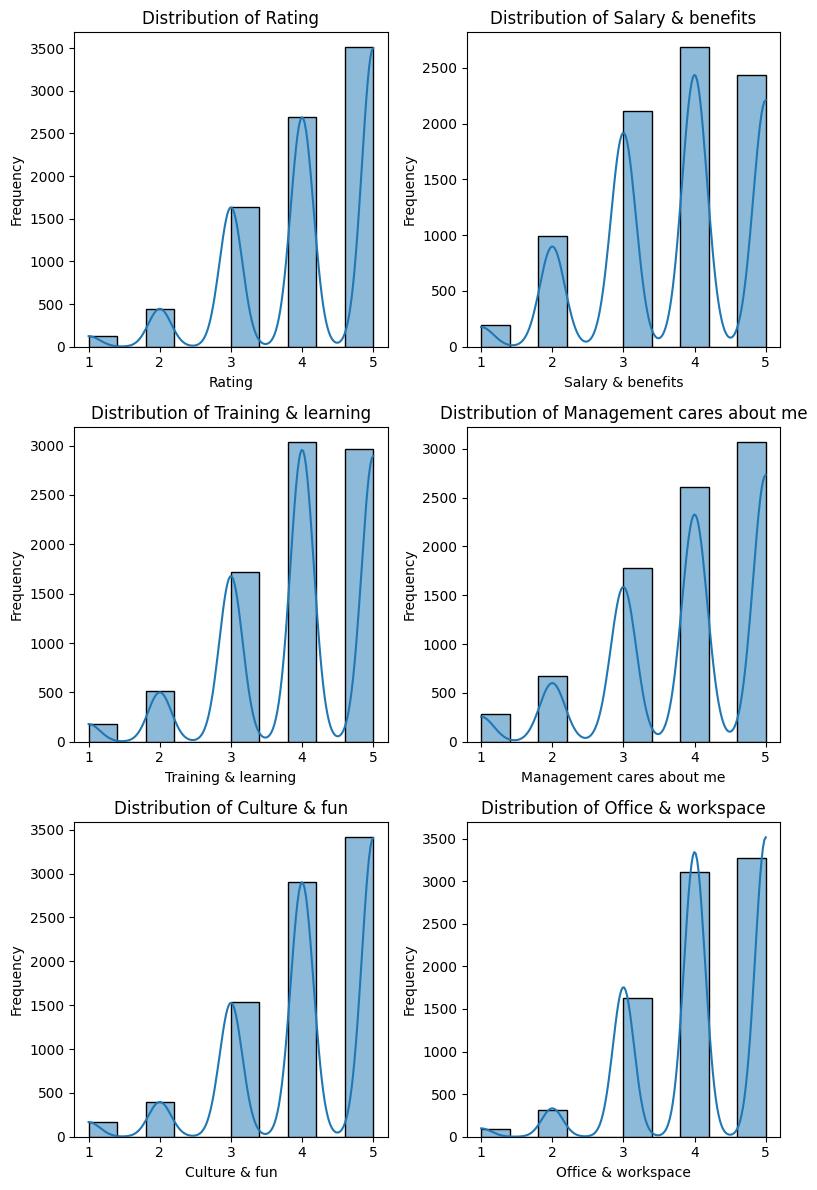

In [89]:
# V·∫Ω bi·ªÉu ƒë·ªì ph√¢n ph·ªëi
plt.figure(figsize=(8, 12))
for i, column in enumerate(eda_columns, 1):
    plt.subplot(3, 2, i)
    sns.histplot(Reviews[column], bins=10, kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [90]:
A= (Reviews[Reviews['label_sentiment'] == 0])
A.head(20)

id        Company Name    Cmt_day  \
3    4           Accenture 2025-02-01   
7    4           Accenture 2022-10-01   
10   4           Accenture 2022-05-01   
11   4           Accenture 2021-02-01   
12   4           Accenture 2019-09-01   
13   4           Accenture 2018-07-01   
14   4           Accenture 2018-06-01   
15   4           Accenture 2018-04-01   
17   4           Accenture 2017-09-01   
25   6             Ahamove 2023-10-01   
26   6             Ahamove 2023-07-01   
34   6             Ahamove 2019-09-01   
42  10  Allexceed Vi·ªát Nam 2020-10-01   
43  10  Allexceed Vi·ªát Nam 2020-08-01   
44  10  Allexceed Vi·ªát Nam 2020-07-01   
46  10  Allexceed Vi·ªát Nam 2019-01-01   
48  10  Allexceed Vi·ªát Nam 2018-07-01   
49  10  Allexceed Vi·ªát Nam 2018-02-01   
50  10  Allexceed Vi·ªát Nam 2018-01-01   
55  12      Alpaca Vietnam 2021-08-01   

                                                Title  \
3                        good environment for fresher   
7                       M√¥i tr∆∞·ªùng ƒëa qu·ªëc gia x·ªãn x√≤   
10                                     M√¥i tr∆∞·ªùng x·ªãn   
11                                      M√¥i t∆∞·ªùng t·ªët   
12  Van phong dep / cong viec phu hop de hoc hoi v...   
13                            Ch√≠nh s√°ch ch∆∞a r√µ r√†ng   
14              Work Space, company policy and salary   
15                                     Good Workspace   
17                                      VƒÉn ph√≤ng ƒë·∫πp   
25                 C√¥ng ty t·∫°m ·ªïn, c·∫ßn c·∫£i thi·ªán th√™m   
26                             ·ªîn ƒë·ªãnh nh∆∞ng mau ch√°n   
34                         Ch√≠nh s√°ch ƒë√£ t·ª´ng r·∫•t t·ªët   
42        ƒê√°nh gi√° chung (nh√¢n vi√™n l√¢u nƒÉm s·ªëng l√¢u)   
43                                     C√¥ng ty r·∫•t t·ªá   
44                      S·∫øp t·ªët, anh ch·ªã h·ªó tr·ª£ nhi·ªÅu   
46                                        C√¥ng ty t·ªët   
48  M√¥i tr∆∞·ªùng l√†m vi·ªác kh√° tho·∫£i m√°i v·ªÅ gi·ªù gi·∫•c,...   
49                                     M√¥i tr∆∞·ªùng t·ªët   
50                     M√¥i tr∆∞·ªùng l√†m vi·ªác th√¢n thi·ªán   
55  M√¥i tr∆∞·ªùng l√†m vi·ªác t·ªët, d·ª± √°n nhi·ªÅu th·ª≠ th√°ch...   

                                         What I liked  \
3   good env. for fresher to learn and improve the...   
7   - Laptop v√† c√°c thi·∫øt b·ªã kh√° x·ªãn x√≤\n- M√¥i tr∆∞...   
10  - VƒÉn ph√≤ng ƒë·∫πp, h∆°i ch·∫≠t.\n- V·ª´a h·ª£p nh·∫•t v·ªõi...   
11  M√¥i tr∆∞·ªùng ·ªïn\nGi·ªù gi·∫•c linh ho·∫°t, c√≥ th·ªÉ wfh ...   
12  van phong dep\ndong nghiep vuive\nsep than thi...   
13  M√¥i tr∆∞·ªùng l√†m vi·ªác t·ªët, th√≠ch h·ª£p cho ng∆∞·ªùi v...   
14  - The company has a good work space and workin...   
15  Company has a good workspace (pantry / kitchen...   
17  VƒÉn ph√≤ng ƒë·∫πp tho√°ng m√°t s·∫°ch s·∫Ω, c√≥ b√£i ƒë·ªÉ xe...   
25  Cho ph√©p wfh 5 ng√†y/th√°ng\nFlexible th·ªùi gian ...   
26  Anh em ƒë·ªìng nghi·ªáp vui v·∫ª ho√† ƒë·ªìng, tu·ª≥ dept m...   
34  h·ªá th·ªëng data, SQL r·∫•t t·ªët, team tech r·∫•t gi·ªèi...   
42  1, V·ªÅ v·∫•n ƒë·ªÅ c√¥ng vi·ªácD·ª± √°n ƒëa ph·∫ßn l√†m v·ªÅ VB....   
43  C√°c anh ch·ªã ƒë·ªìng nghi·ªáp trong c√¥ng ty vui v·∫ª, ...   
44  L√†m vi·ªác vs c√¥ng ty nh·∫≠t, c√≥ h·ªó tr·ª£ d·∫°y ti·∫øng ...   
46  Th·ªùi gian l√†m vi·ªác linh ho·∫°t, l∆∞∆°ng th∆∞·ªüng t∆∞∆°...   
48  Gi·ªù gi·∫•c kh√° tho·∫£i m√°i\nVƒÉn ph√≤ng t·∫°m ·ªïn\nC√≥ l...   
49  L∆∞∆°ng kh√° cao, c√≥ ch·∫ø ƒë·ªô gi·ªØ ng∆∞·ªùi t√†i t·ªët, tƒÉ...   
50  - Gi·ªù gi·∫•c l√†m vi·ªác tho·∫£i m√°i, linh ƒë·ªông.\n- V...   
55  M√¥i tr∆∞·ªùng tr·∫ª trung nƒÉng ƒë·ªông, s·∫øp th√¢n thi·ªán...   

                          Suggestions for improvement  Rating  \
3   Need to forcus more on benefit and evaluate co...       3   
7   S·ªë l∆∞·ª£ng nh√¢n vi√™n tƒÉng d·∫´n t·ªõi vƒÉn ph√≤ng h∆°i ...       4   
10  - C·∫ßn c·∫£i thi·ªán c√°c ph√∫c l·ª£i v√† ch√≠nh s√°ch cho...       4   
11  Kh√¥ng th·ªÉ c·∫£i thi·ªán c√°i j c·∫£, v√¨ cty m·∫π ·ªü ph√°p...       2  

In [91]:
# prompt: Give list of columns from A dataframe

Reviews.columns

Index(['id', 'Company Name', 'Cmt_day', 'Title', 'What I liked',
       'Suggestions for improvement', 'Rating', 'Salary & benefits',
       'Training & learning', 'Management cares about me', 'Culture & fun',
       'Office & workspace', 'Recommend?', 'Company Type', 'Company industry',
       'Company size', 'Country', 'Working days', 'Overtime Policy',
       'review_text', 'processed_text', 'pos_count', 'neg_count',
       'label_sentiment', 'Review_Year', 'combined_text', 'review_len',
       'text_processed'],
      dtype='object')

# Y√™u c·∫ßu 1

### EDA cho y√™u c·∫ßu 1

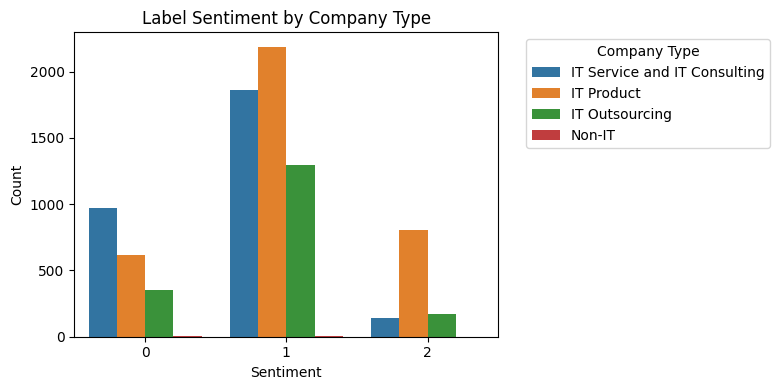

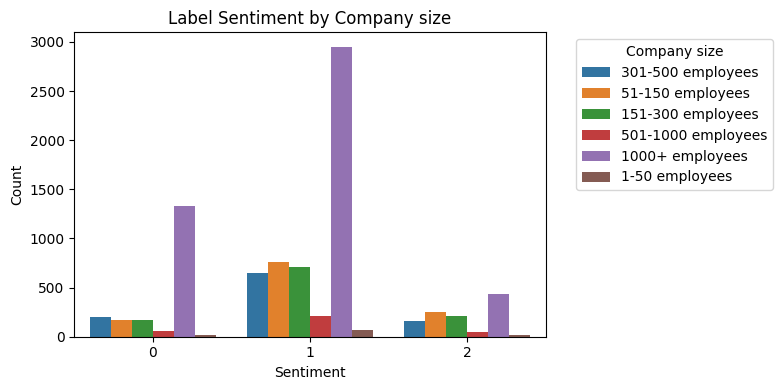

In [92]:
# Chu·∫©n h√≥a c·ªôt Cmt_daydatetime
Reviews['Cmt_day'] = pd.to_datetime(Reviews['Cmt_day'], format="%B %Y", errors='coerce')

#  T·∫°o c·ªôt m·ªõi  year
Reviews['Review_Year'] = Reviews['Cmt_day'].dt.year

#  Danh s√°ch c√°c nh√≥m c·∫ßn ph√¢n t√≠ch
group_columns = ['Company Type', 'Company size']

# V·∫Ω bi·ªÉu ƒë·ªì ƒë·∫øm cho t·ª´ng nh√≥m
for group in group_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=Reviews, x='label_sentiment', hue=group)
    plt.title(f'Label Sentiment by {group}')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.legend(title=group, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


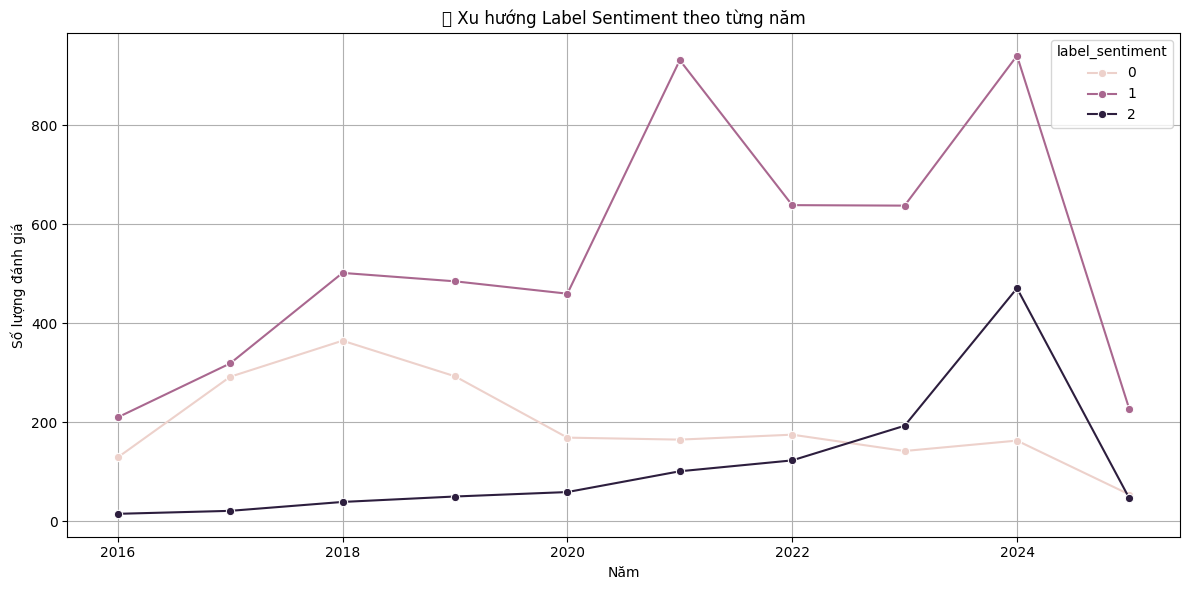

In [93]:
# Year
Reviews['Cmt_day'] = pd.to_datetime(Reviews['Cmt_day'], format='%B %Y', errors='coerce')
Reviews['Review_Year'] = Reviews['Cmt_day'].dt.year

# ƒê·∫øm s·ªë l∆∞·ª£ng sentiment theo t·ª´ng nƒÉm
sentiment_by_year = Reviews.groupby(['Review_Year', 'label_sentiment']).size().reset_index(name='count')

# V·∫Ω bi·ªÉu ƒë·ªì line
plt.figure(figsize=(12, 6))
sns.lineplot(data=sentiment_by_year, x='Review_Year', y='count', hue='label_sentiment', marker='o')
plt.title('üìà Xu h∆∞·ªõng Label Sentiment theo t·ª´ng nƒÉm')
plt.xlabel('NƒÉm')
plt.ylabel('S·ªë l∆∞·ª£ng ƒë√°nh gi√°')
plt.grid(True)
plt.tight_layout()
plt.show()


In [94]:
import plotly.express as px
import plotly.graph_objects as go

# T√≠nh ƒëi·ªÉm trung b√¨nh theo qu·ªëc gia
country_sentiment = Reviews.groupby("Country")["label_sentiment"].mean().reset_index()

# T·∫°o b·∫£n ƒë·ªì choropleth
fig = px.choropleth(
    country_sentiment,
    locations="Country",
    locationmode="country names",
    color="label_sentiment",
    color_continuous_scale="RdYlGn",  # ƒê·ªè -> V√†ng -> Xanh
    range_color=(0, 2),
    title="Average Sentiment by Country",
)

# T·∫Øt vi·ªÅn b·∫£n ƒë·ªì
fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='natural earth'
    ),
    margin=dict(l=0, r=0, t=50, b=0),
)

# L·∫•y th√¥ng tin t·ªça ƒë·ªô
import pycountry
from geopy.geocoders import Nominatim
import time

geolocator = Nominatim(user_agent="geoapi")

country_sentiment["lat"] = None
country_sentiment["lon"] = None

for idx, row in country_sentiment.iterrows():
    try:
        location = geolocator.geocode(row["Country"], timeout=10)
        if location:
            country_sentiment.at[idx, "lat"] = location.latitude
            country_sentiment.at[idx, "lon"] = location.longitude
        time.sleep(1)  # tr√°nh b·ªã ch·∫∑n do qu√° nhi·ªÅu request
    except:
        pass

# Th√™m t√™n qu·ªëc gia
fig.add_trace(go.Scattergeo(
    locationmode='country names',
    lon=country_sentiment["lon"],
    lat=country_sentiment["lat"],
    text=country_sentiment["Country"],
    mode='text',
    showlegend=False,
    textfont=dict(color='black', size=9)
))

fig.show()


In [95]:
# T√≠nh ƒëi·ªÉm trung b√¨nh label_sentiment theo qu·ªëc gia
country_sentiment = Reviews.groupby("Country")["label_sentiment"].mean().reset_index()

# S·∫Øp x·∫øp gi·∫£m d·∫ßn
top_countries = country_sentiment.sort_values(by="label_sentiment", ascending=False)

# L·∫•y top 10
top_10 = top_countries.head(10)

print("Top 10 Countries by Sentiment:")
display(top_10)

Top 10 Countries by Sentiment:


Country  label_sentiment
15       Sweden         1.528571
5       Estonia         1.500000
4       Denmark         1.412844
14  South Korea         1.362473
0     Australia         1.241206
13    Singapore         1.135309
12       Norway         1.126866
3        Canada         1.066667
1       Belgium         1.013333
2      Cambodia         1.000000

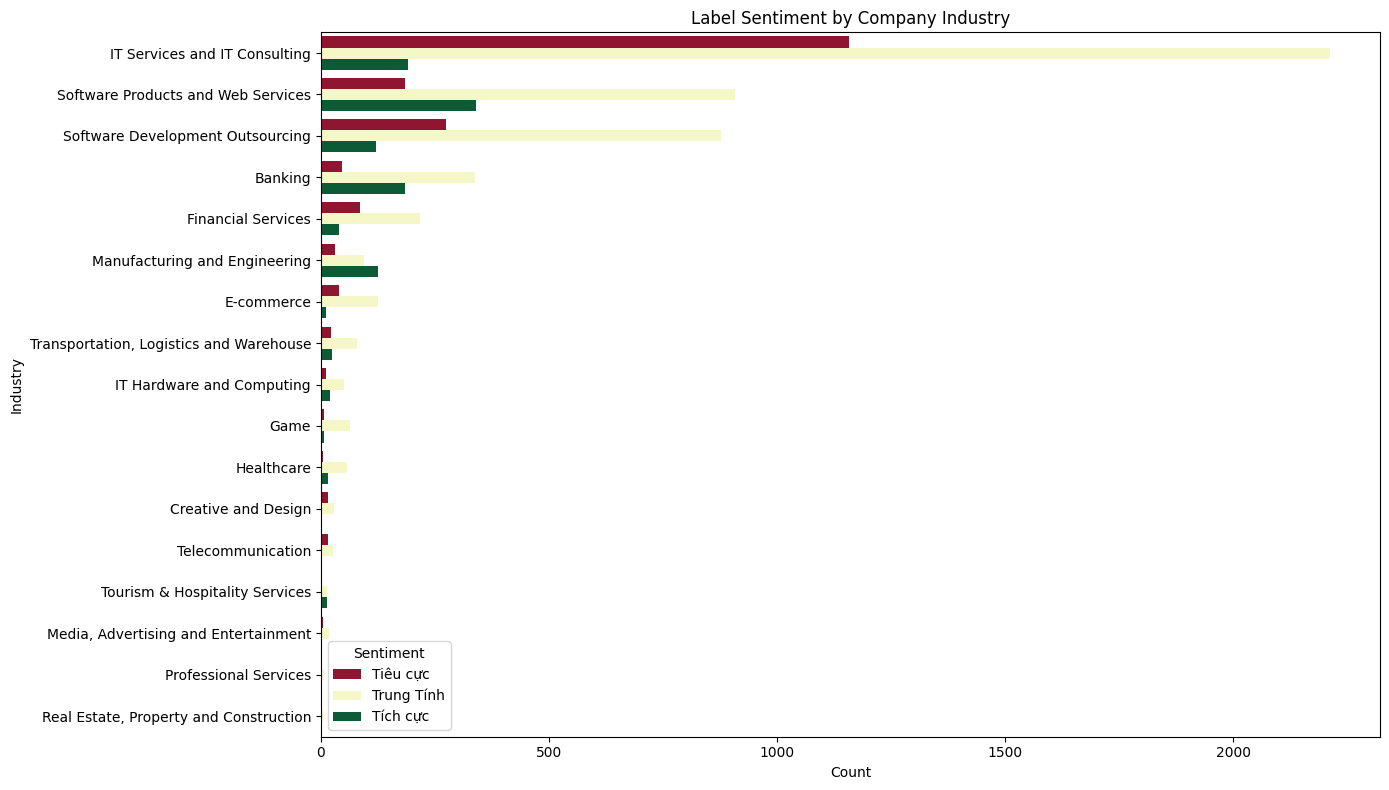

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 8))

# S·∫Øp x·∫øp
industry_order = Reviews['Company industry'].value_counts().index

sns.countplot(
    data=Reviews,
    y='Company industry',
    hue='label_sentiment',
    order=industry_order,
    palette='RdYlGn'
)

plt.title('Label Sentiment by Company Industry')
plt.xlabel('Count')
plt.ylabel('Industry')
plt.legend(title='Sentiment', labels=['Ti√™u c·ª±c', 'Trung T√≠nh', 'T√≠ch c·ª±c'])
plt.tight_layout()
plt.show()


In [97]:
print(Reviews.columns)


Index(['id', 'Company Name', 'Cmt_day', 'Title', 'What I liked',
       'Suggestions for improvement', 'Rating', 'Salary & benefits',
       'Training & learning', 'Management cares about me', 'Culture & fun',
       'Office & workspace', 'Recommend?', 'Company Type', 'Company industry',
       'Company size', 'Country', 'Working days', 'Overtime Policy',
       'review_text', 'processed_text', 'pos_count', 'neg_count',
       'label_sentiment', 'Review_Year', 'combined_text', 'review_len',
       'text_processed'],
      dtype='object')


## MODEL

In [104]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import pandas as pd

In [105]:
# VƒÉn b·∫£n & d·ªØ li·ªáu s·ªë
text_col = 'text_processed'
numeric_cols = [
    'Salary & benefits', 'Training & learning', 'Management cares about me',
    'Culture & fun', 'Office & workspace',
    'pos_count', 'neg_count', 'Review_Year'
]

# T·∫°o ƒë·∫∑c tr∆∞ng ƒë·∫ßu v√†o v√† nh√£n
X = Reviews[[text_col] + numeric_cols]
y = Reviews['label_sentiment']

# Chia d·ªØ li·ªáu
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# T·∫°o preprocessor k·∫øt h·ª£p TF-IDF v√† chu·∫©n h√≥a
preprocessor = ColumnTransformer(transformers=[
    ('tfidf', TfidfVectorizer(norm='l2', max_features=768), text_col),
    ('num', StandardScaler(), numeric_cols)
])

In [106]:
# M√¥ h√¨nh c·∫ßn ƒë√°nh gi√°
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# Hu·∫•n luy·ªán v√† ƒë√°nh gi√°
for name, model in models.items():
    print(f"\nTraining {name}...")
    pipe = Pipeline([
        ('preprocess', preprocessor),
        ('classifier', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred, digits=3))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    # L∆∞u m√¥ h√¨nh pipeline ƒë·∫ßy ƒë·ªß
    joblib.dump(pipe, f'{name}_pipeline.pkl')
    print(f"Saved model to {name}_pipeline.pkl")


Training Logistic Regression...
Model: Logistic Regression
              precision    recall  f1-score   support

           0      0.843     0.787     0.814       389
           1      0.924     0.947     0.935      1071
           2      1.000     1.000     1.000       224

    accuracy                          0.917      1684
   macro avg      0.922     0.911     0.916      1684
weighted avg      0.916     0.917     0.916      1684

Confusion Matrix:
 [[ 306   83    0]
 [  57 1014    0]
 [   0    0  224]]
Saved model to Logistic Regression_pipeline.pkl

Training SVM...
Model: SVM
              precision    recall  f1-score   support

           0      0.804     0.748     0.775       389
           1      0.890     0.934     0.911      1071
           2      1.000     0.884     0.938       224

    accuracy                          0.884      1684
   macro avg      0.898     0.855     0.875      1684
weighted avg      0.885     0.884     0.883      1684

Confusion Matrix:
 [[ 291   

In [111]:
from tensorflow.keras.layers import Bidirectional

texts = Reviews['text_processed'].tolist()
labels = Reviews['label_sentiment'].values

max_words = 2000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X_pad = pad_sequences(sequences, maxlen=max_len)

X_train, X_test, y_train, y_test = train_test_split(X_pad, labels, test_size=0.2, random_state=42, stratify=labels)

model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    SpatialDropout1D(0.3),
    Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_test, y_test)
)


Model: "sequential_2"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ embedding_2 (Embedding)              ‚îÇ ?                           ‚îÇ     0 (unbuilt) ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ spatial_dropout1d_2                  ‚îÇ ?                           ‚îÇ               0 ‚îÇ
‚îÇ (SpatialDropout1D)                   ‚îÇ                             ‚îÇ                 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ bidirectional_1 (Bidirectional)      ‚îÇ ?                           ‚îÇ     0 (unbuilt) ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_4 (Dense)                      ‚îÇ ?                           ‚îÇ     0 (unbuilt) ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_2 (Dropout)                  ‚îÇ ?                           ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_5 (Dense)                      ‚îÇ ?                           ‚îÇ     0 (unbuilt) ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
106/106 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 16s 107ms/step - accuracy: 0.6084 - loss: 0.9349 - val_accuracy: 0.6443 - val_loss: 0.8092
Epoch 2/20
106/106 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 104ms/step - accuracy: 0.6484 - loss: 0.7877 - val_accuracy: 0.6485 - val_loss: 0.7800
Epoch 3/20
106/106 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 108ms/step - accuracy: 0.6682 - loss: 0.7254 - val_accuracy: 0.6562 - val_loss: 0.7787
Epoch 4/20
106/106 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 106ms/step - accuracy: 0.6894 - loss: 0.6843 - val_accuracy: 0.6461 - val_loss: 0.7924
Epoch 5/20
106/106 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 109ms/step - accuracy: 0.7213 - loss: 0.6501 - val_accuracy: 0.6283 - val_loss: 0.8101
Epoch 6/20
106/106 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 107ms/step - accuracy: 0.7278 - loss: 0.6260 - val_accuracy: 

In [112]:
# L∆∞u m√¥ h√¨nh sau khi hu·∫•n luy·ªán xong
model.save('sentiment_analysis_model_lstm.h5')
print("Model saved as 'sentiment_analysis_model_lstm.h5'")

Model saved as 'sentiment_analysis_model_lstm.h5'


In [113]:
# D·ª± ƒëo√°n tr√™n t·∫≠p test
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  # Chuy·ªÉn ƒë·ªïi ƒë·∫ßu ra softmax th√†nh class labels

53/53 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 23ms/step


In [114]:
classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive'])

'              precision    recall  f1-score   support\n\n    Negative       0.43      0.43      0.43       389\n     Neutral       0.68      0.74      0.71      1071\n    Positive       0.35      0.21      0.26       224\n\n    accuracy                           0.60      1684\n   macro avg       0.49      0.46      0.47      1684\nweighted avg       0.58      0.60      0.59      1684\n'

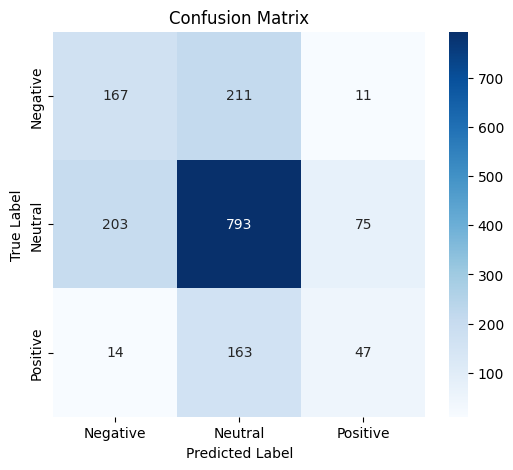

In [115]:
# In ra confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

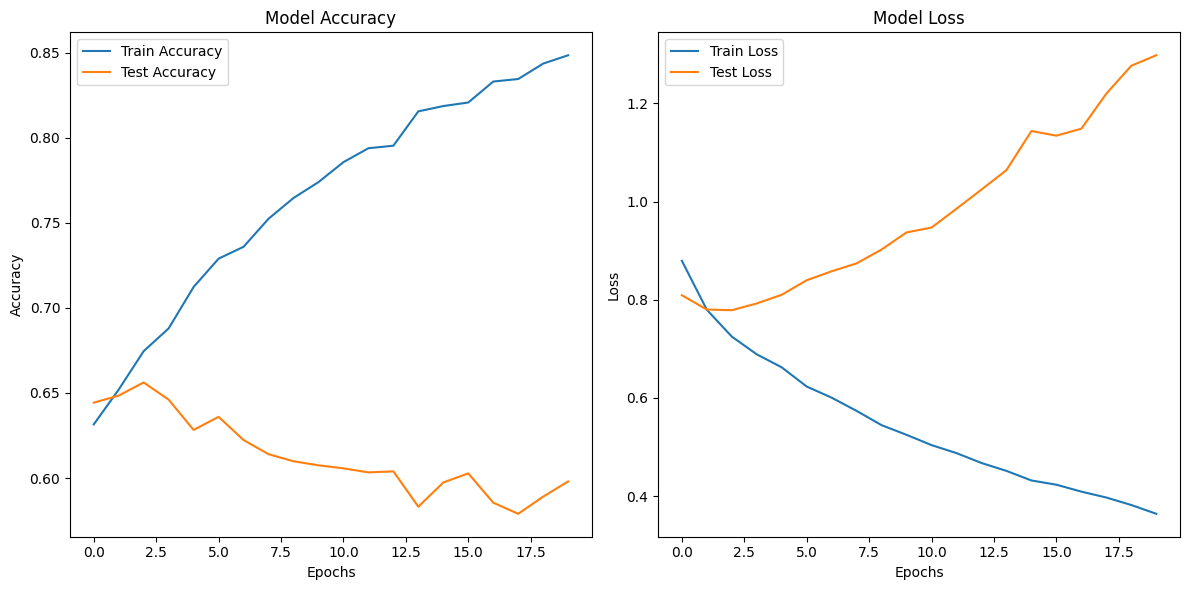

In [116]:
#  Plot Accuracy & Loss curves
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [117]:
# T√≠nh ROC curve cho t·ª´ng l·ªõp
fpr = {}
tpr = {}
roc_auc = {}

In [118]:
n_classes = 3  # S·ªë l·ªõp c·∫£m x√∫c: Negative, Neutral, Positive
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, model.predict(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


53/53 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 13ms/step
53/53 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 15ms/step
53/53 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 15ms/step


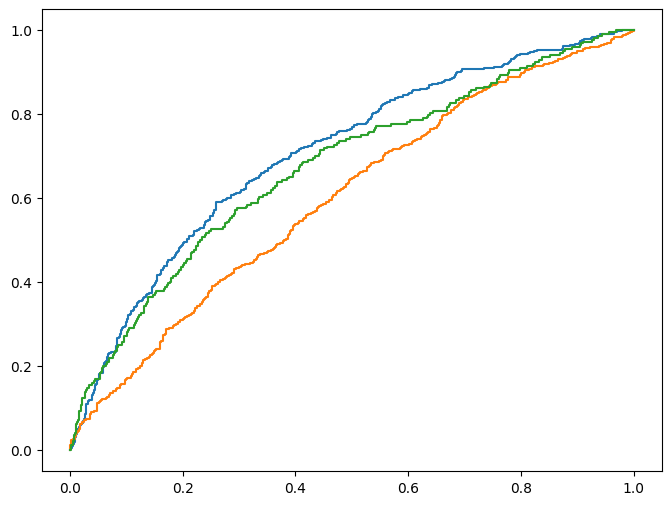

In [119]:
# V·∫Ω ROC curve cho t·ª´ng l·ªõp
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')


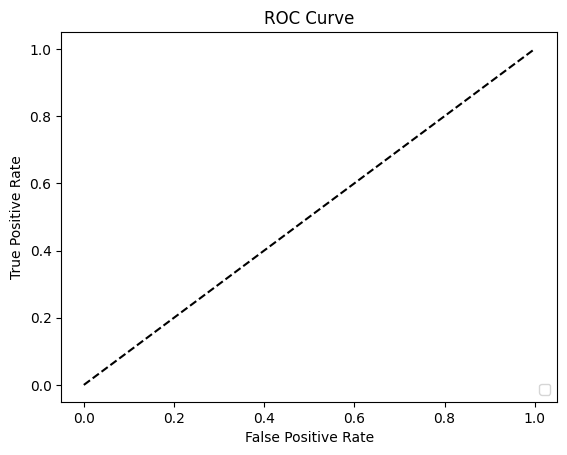

In [120]:
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# M√¥ h√¨nh Random Forest v·ªõi PhoBERT embeddings


In [122]:
phobert = 'vinai/phobert-base'
tokenizer = AutoTokenizer.from_pretrained(phobert)
model = AutoModel.from_pretrained(phobert)

In [123]:
def get_phobert_embedding(texts):
    features = []
    with torch.no_grad():
        for text in tqdm(texts):
            input_ids = tokenizer.encode(text, return_tensors='pt', truncation=True, max_length=128)
            outputs = model(input_ids)
            embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
            features.append(embedding)
    return np.array(features)


In [127]:
# Ti·ªÅn x·ª≠ l√Ω v√† l·∫•y embedding PhoBERT
X_phobert = get_phobert_embedding(Reviews['text_processed'].tolist())
y = Reviews['label_sentiment'].values


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8417/8417 [05:55<00:00, 23.65it/s]


In [128]:
# Chia d·ªØ li·ªáu train v√† test
X_train, X_test, y_train, y_test = train_test_split(X_phobert, y, test_size=0.2, random_state=42, stratify=y)


In [129]:
# Hu·∫•n luy·ªán m√¥ h√¨nh Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [130]:
# L∆∞u m√¥ h√¨nh Random Forest sau khi hu·∫•n luy·ªán
import joblib
joblib.dump(clf, 'random_forest_model.pkl')
print("Model saved as 'random_forest_model.pkl'")

Model saved as 'random_forest_model.pkl'


In [131]:
classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive'])

'              precision    recall  f1-score   support\n\n    Negative       0.56      0.09      0.16       389\n     Neutral       0.64      0.97      0.78      1071\n    Positive       0.50      0.00      0.01       224\n\n    accuracy                           0.64      1684\n   macro avg       0.57      0.36      0.31      1684\nweighted avg       0.61      0.64      0.53      1684\n'

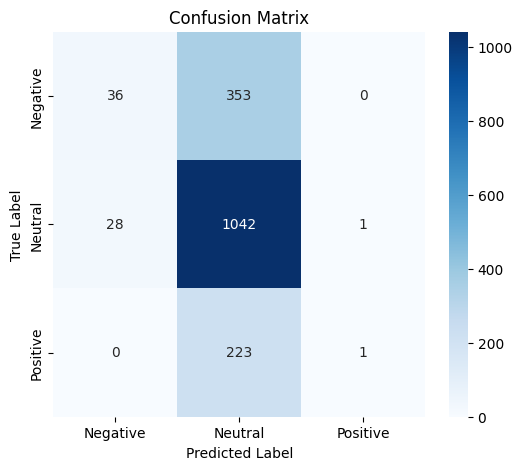

In [132]:
# In ra confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

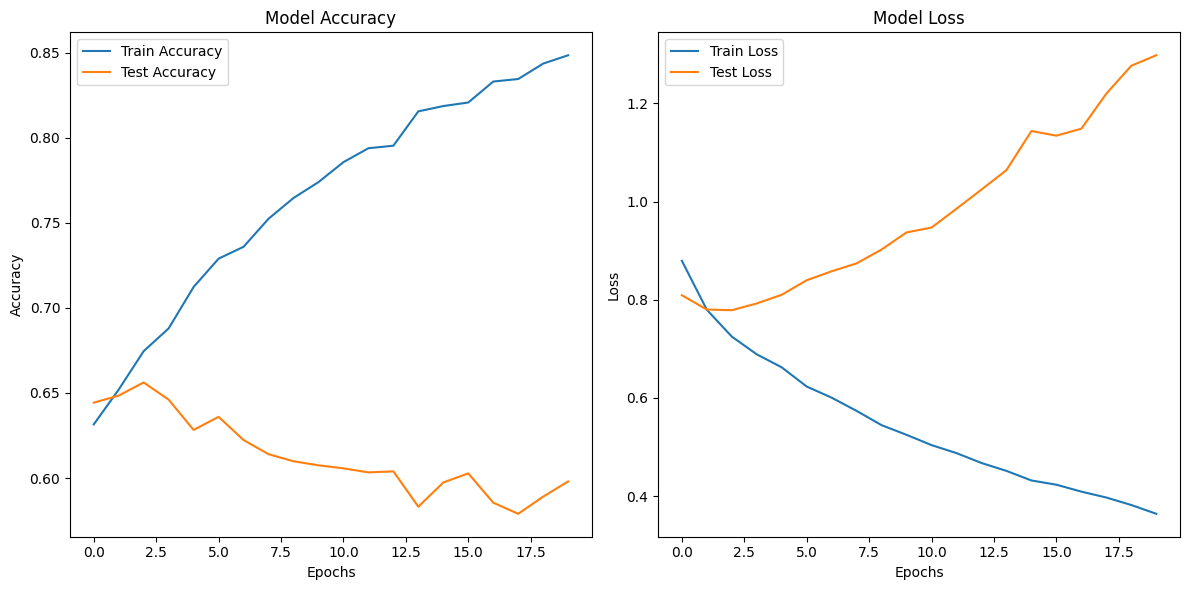

In [133]:
## 4. ROC Curve (cho t·ª´ng l·ªõp)
fpr = {}
tpr = {}
roc_auc = {}
# Plot Accuracy & Loss curves
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [134]:
# ROC Curve (cho t·ª´ng l·ªõp)
fpr = {}
tpr = {}
roc_auc = {}


In [135]:
n_classes = 3  # S·ªë l·ªõp c·∫£m x√∫c: Negative, Neutral, Positive
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, clf.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

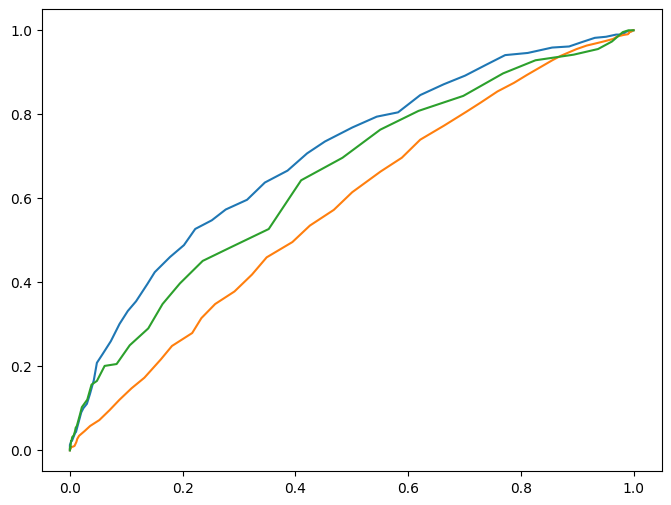

In [136]:
# V·∫Ω ROC curve cho t·ª´ng l·ªõp
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')


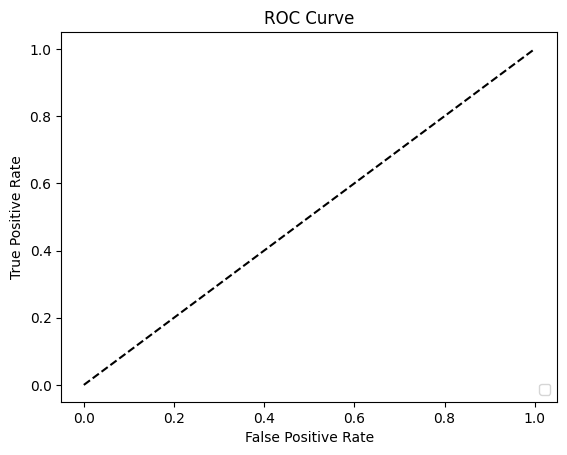

In [137]:
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


# PH√ÇN C·ª§M TH√îNG TIN REVIEW

In [138]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic

In [140]:
vectorizer = CountVectorizer(max_features=2000)
X_count = vectorizer.fit_transform(Reviews['text_processed'])

In [141]:
K = range(2, 10)
inertia = []
silhouette = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_k = kmeans.fit_predict(X_count)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_count, labels_k))

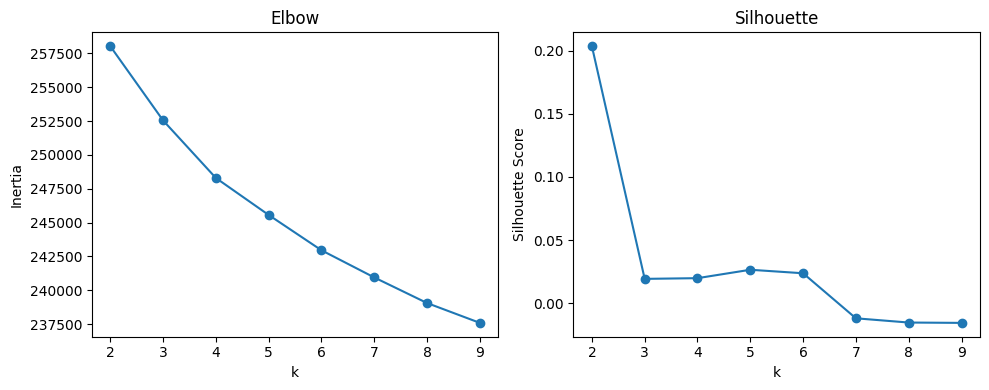

In [142]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(K, inertia, marker='o')
plt.title('Elbow')
plt.xlabel('k'); plt.ylabel('Inertia')
plt.subplot(1,2,2)
plt.plot(K, silhouette, marker='o')
plt.title('Silhouette')
plt.xlabel('k'); plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()


In [144]:
# Ch·ªçn s·ªë c·ª•m
k = 2
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_count)
Reviews['cluster'] = labels

In [146]:
# Gi·∫£m chi·ªÅu ƒë·ªÉ scatter
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_count.toarray())
Reviews['x_pca'] = X_pca[:, 0]
Reviews['y_pca'] = X_pca[:, 1]

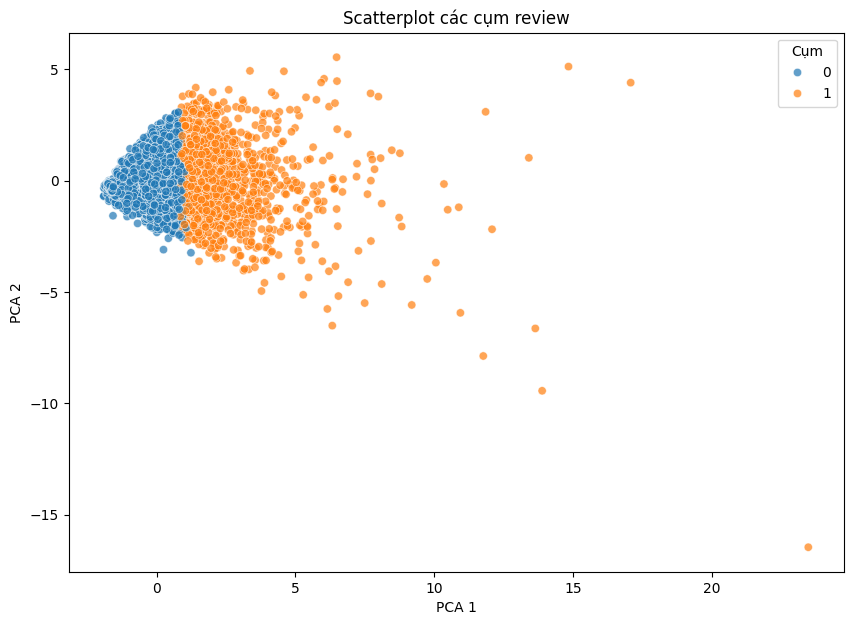

In [148]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=Reviews, x='x_pca', y='y_pca', hue='cluster', palette='tab10', alpha=0.7)
plt.title('Scatterplot c√°c c·ª•m review')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='C·ª•m')
plt.show()

In [149]:
# T√≠nh to√°n Silhouette Score cho KMeans
sil_score_kmeans = silhouette_score(X_count, labels, metric='euclidean')

# In ra k·∫øt qu·∫£ Silhouette Score cho KMeans
print(f"Silhouette Score (KMeans): {sil_score_kmeans}")

Silhouette Score (KMeans): 0.20373745547222719


In [151]:
import hdbscan

vectorizer = CountVectorizer(max_features=2000)
X_count = vectorizer.fit_transform(Reviews['text_processed'])


In [153]:
# HDBSCAN model
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5, metric='euclidean')
labels_hdbscan = hdbscan_model.fit_predict(X_count)

# Add cluster labels to dataframe
Reviews['cluster_hdbscan'] = labels_hdbscan


In [154]:
# Reducing dimensions to 2D using PCA for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_count.toarray())
Reviews['x_pca'] = X_pca[:, 0]
Reviews['y_pca'] = X_pca[:, 1]


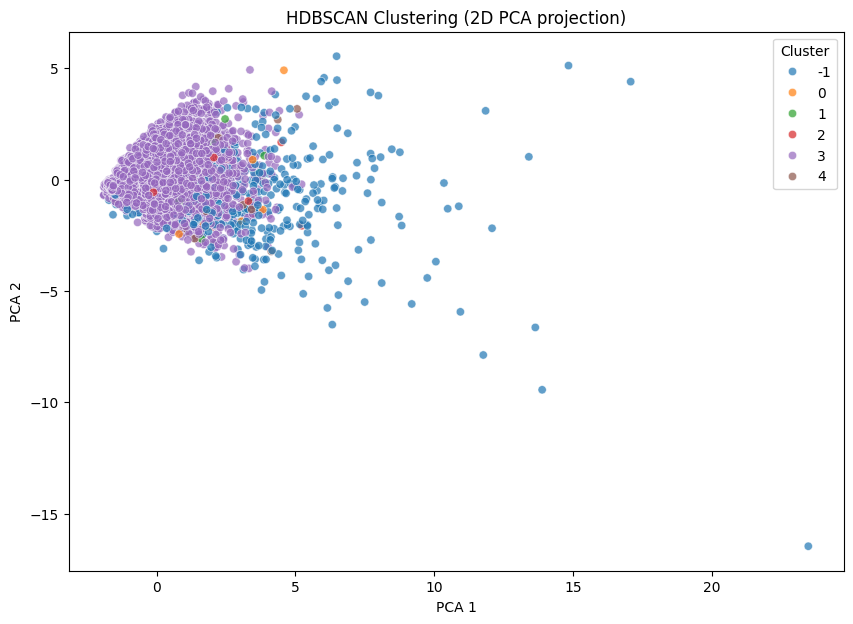

In [155]:
# üéØ Improved HDBSCAN Clustering Visualization (PCA 2D)

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=Reviews,
    x='x_pca',
    y='y_pca',
    hue='cluster_hdbscan',
    palette='Set2',
    edgecolor='black',
    s=60,
    alpha=0.8
)
plt.title('Bi·ªÉu ƒë·ªì ph√¢n c·ª•m HDBSCAN (PCA 2D)', fontsize=14)
plt.xlabel('Th√†nh ph·∫ßn PCA 1')
plt.ylabel('Th√†nh ph·∫ßn PCA 2')
plt.legend(title='C·ª•m', loc='best')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [156]:
# L∆∞u m√¥ h√¨nh HDBSCAN
joblib.dump(hdbscan_model, 'hdbscan_model.pkl')

# In ra th√¥ng b√°o l∆∞u th√†nh c√¥ng
print("M√¥ h√¨nh HDBSCAN ƒë√£ ƒë∆∞·ª£c l∆∞u th√†nh c√¥ng.")

M√¥ h√¨nh HDBSCAN ƒë√£ ƒë∆∞·ª£c l∆∞u th√†nh c√¥ng.


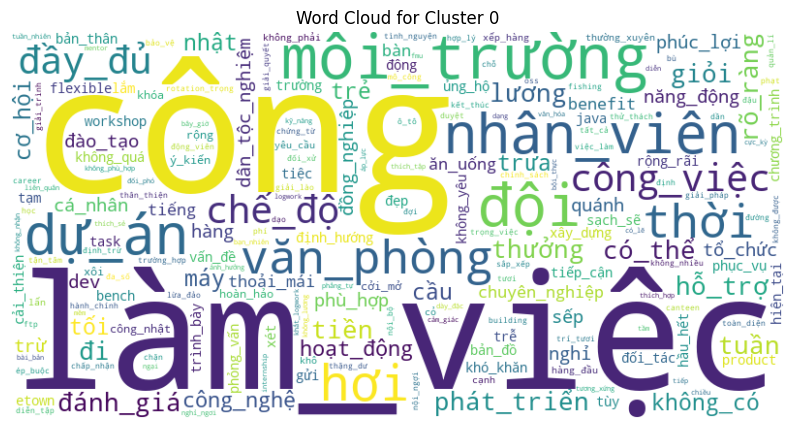

In [159]:
from wordcloud import WordCloud

# T·∫°o WordCloud cho c·ª•m ƒë·∫ßu ti√™n (cluster 0)
cluster_0_reviews = Reviews[Reviews['cluster_hdbscan'] == 0]['text_processed']

# T·∫°o WordCloud cho c·ª•m ƒë·∫ßu ti√™n
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(cluster_0_reviews))

# Hi·ªÉn th·ªã WordCloud
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Cluster 0')
plt.axis('off')
plt.show()

### XU·∫§T T·ª™ KH√ìA ƒê·∫∂C TR∆ØNG, WORDCLOUD, TH·ªêNG K√ä

In [160]:
# V·ªõi KMeans
terms = vectorizer.get_feature_names_out()
num_keywords = 10
for i in range(k):
    print(f"\nTop {num_keywords} t·ª´ kh√≥a c·ª•m {i}:")
    top_indices = kmeans.cluster_centers_[i].argsort()[::-1][:num_keywords]
    print(', '.join(terms[j] for j in top_indices))



Top 10 t·ª´ kh√≥a c·ª•m 0:
m√¥i_tr∆∞·ªùng, l∆∞∆°ng, l√†m_vi·ªác, c√¥ng, nh√¢n_vi√™n, vƒÉn_ph√≤ng, d·ª±_√°n, c√¥ng_vi·ªác, s·∫øp, th√¢n_thi·ªán

Top 10 t·ª´ kh√≥a c·ª•m 1:
c√¥ng, l√†m_vi·ªác, nh√¢n_vi√™n, m√¥i_tr∆∞·ªùng, l∆∞∆°ng, ƒëi, c√¥ng_vi·ªác, ƒë·ªôi, ph√°t_tri·ªÉn, ƒë·ªìng_nghi·ªáp


In [162]:
# L·∫•y danh s√°ch c√°c t·ª´ trong t·ª´ ƒëi·ªÉn
terms = vectorizer.get_feature_names_out()
num_keywords = 10
# Duy·ªát qua t·ª´ng c·ª•m v√† in ra c√°c t·ª´ kh√≥a quan tr·ªçng
for i in np.unique(labels_hdbscan):
    if i != -1:  # Lo·∫°i b·ªè c√°c ƒëi·ªÉm nhi·ªÖu c√≥ nh√£n -1
        print(f"\nTop {num_keywords} t·ª´ kh√≥a trong c·ª•m {i}:")
        cluster_reviews = Reviews[Reviews['cluster_hdbscan'] == i]['text_processed']
        cluster_matrix = vectorizer.transform(cluster_reviews)
        
        # T√≠nh t·ªïng t·∫ßn su·∫•t c√°c t·ª´ trong c·ª•m n√†y
        word_counts = np.asarray(cluster_matrix.sum(axis=0)).flatten()
        
        # L·∫•y c√°c t·ª´ c√≥ t·∫ßn su·∫•t cao nh·∫•t
        top_indices = word_counts.argsort()[::-1][:num_keywords]
        
        # In ra c√°c t·ª´ kh√≥a
        print(', '.join(terms[j] for j in top_indices))


Top 10 t·ª´ kh√≥a trong c·ª•m 0:
c√¥ng, l√†m_vi·ªác, m√¥i_tr∆∞·ªùng, ƒë·ªôi, d·ª±_√°n, nh√¢n_vi√™n, h∆°i, th·ªùi, vƒÉn_ph√≤ng, ƒë·∫ßy_ƒë·ªß

Top 10 t·ª´ kh√≥a trong c·ª•m 1:
l√†m_vi·ªác, c√¥ng, c√¥ng_vi·ªác, nh√¢n_vi√™n, m√¥i_tr∆∞·ªùng, ƒëi, l∆∞∆°ng, ph√°t_tri·ªÉn, d·ª±_√°n, ƒë√°nh_gi√°

Top 10 t·ª´ kh√≥a trong c·ª•m 2:
c√¥ng, nh√¢n_vi√™n, l√†m_vi·ªác, l∆∞∆°ng, m√¥i_tr∆∞·ªùng, c√≥_th·ªÉ, ƒë·ªôi, ƒëi, ch·∫ø_ƒë·ªô, ƒë·ªìng_nghi·ªáp

Top 10 t·ª´ kh√≥a trong c·ª•m 3:
l√†m_vi·ªác, m√¥i_tr∆∞·ªùng, l∆∞∆°ng, c√¥ng, nh√¢n_vi√™n, vƒÉn_ph√≤ng, d·ª±_√°n, c√¥ng_vi·ªác, th√¢n_thi·ªán, ƒë·ªìng_nghi·ªáp

Top 10 t·ª´ kh√≥a trong c·ª•m 4:
c√¥ng, l√†m_vi·ªác, ƒëi, ƒë·ªôi, l∆∞∆°ng, nh√¢n_vi√™n, c√¥ng_vi·ªác, m√¥i_tr∆∞·ªùng, kh√¥ng_c√≥, h∆°i


### PH√ÇN T√çCH S√ÇU THEO C√îNG TY

In [165]:
# L·∫∑p qua t·ª´ng c√¥ng ty trong c·ªôt 'Company Name'
for company in Reviews['Company Name'].unique():
    print(f'\n--- {company} ---')
    
    # Th·ªëng k√™ s·ªë l∆∞·ª£ng c√°c gi√° tr·ªã trong c·ªôt 'cluster_hdbscan' cho m·ªói c√¥ng ty
    print(Reviews[Reviews['Company Name'] == company]['cluster_hdbscan'].value_counts())



--- Accenture ---
cluster_hdbscan
3    18
Name: count, dtype: int64

--- Adnovum Vietnam ---
cluster_hdbscan
 3    4
-1    2
Name: count, dtype: int64

--- Ahamove ---
cluster_hdbscan
 3    11
-1     1
Name: count, dtype: int64

--- Allexceed Vi·ªát Nam ---
cluster_hdbscan
 3    16
-1     1
Name: count, dtype: int64

--- Alpaca Vietnam ---
cluster_hdbscan
3    5
Name: count, dtype: int64

--- ANDPAD VietNam Co., Ltd ---
cluster_hdbscan
3    10
Name: count, dtype: int64

--- ARIS Vietnam ---
cluster_hdbscan
3    13
Name: count, dtype: int64

--- Asilla ---
cluster_hdbscan
3    10
Name: count, dtype: int64

--- Athena Studio ---
cluster_hdbscan
3    25
Name: count, dtype: int64

--- Aviron ---
cluster_hdbscan
3    4
Name: count, dtype: int64

--- AZoom VietNam ---
cluster_hdbscan
3    5
Name: count, dtype: int64

--- AZPLAYS Co., LTD ---
cluster_hdbscan
3    6
Name: count, dtype: int64

--- BAN VIEN CORPORATION ---
cluster_hdbscan
3    42
Name: count, dtype: int64

--- bbv Vietnam ---
c

### L∆ØU B·∫¢NG SUMMARY TOPIC + T·ª™ KH√ìA

In [167]:
# L·∫∑p qua c√°c c·ª•m trong HDBSCAN
cluster_summary = []

for cluster in set(labels_hdbscan):  # labels_hdbscan l√† nh√£n ph√¢n c·ª•m t·ª´ HDBSCAN
    if cluster == -1:  # Lo·∫°i b·ªè ƒëi·ªÉm nhi·ªÖu (-1 l√† ƒëi·ªÉm nhi·ªÖu trong HDBSCAN)
        continue
    
    # T√¨m c√°c t·ª´ kh√≥a cho c·ª•m n√†y (d√πng CountVectorizer ƒë·ªÉ l·∫•y t·ª´ kh√≥a)
    cluster_reviews = Reviews[Reviews['cluster_hdbscan'] == cluster]['text_processed']
    cluster_matrix = vectorizer.transform(cluster_reviews)
    
    # T√≠nh t·ªïng t·∫ßn su·∫•t t·ª´ trong c·ª•m n√†y
    word_counts = np.asarray(cluster_matrix.sum(axis=0)).flatten()
    
    # L·∫•y c√°c t·ª´ c√≥ t·∫ßn su·∫•t cao nh·∫•t
    top_indices = word_counts.argsort()[::-1][:10]  # Top 10 t·ª´ kh√≥a
    kw_list = [str(vectorizer.get_feature_names_out()[i]) for i in top_indices]  # Chuy·ªÉn th√†nh chu·ªói
    
    # ƒê·∫øm s·ªë l∆∞·ª£ng ƒë√°nh gi√° trong c·ª•m n√†y
    count = len(cluster_reviews)
    
    # Th√™m th√¥ng tin c·ª•m v√†o danh s√°ch t·ªïng h·ª£p
    cluster_summary.append({
        'cluster': cluster, 
        'num_reviews': count, 
        'keywords': ', '.join(kw_list)  # Join l·∫°i c√°c t·ª´ kh√≥a th√†nh chu·ªói
    })

# L∆∞u k·∫øt qu·∫£ v√†o Excel
cluster_summary_df = pd.DataFrame(cluster_summary)
cluster_summary_df.to_excel('hdbscan_cluster_summary.xlsx', index=False)
